In [125]:
import numpy as np
from numpy.linalg import eig
from numpy.linalg import inv,pinv
import pandas as pd
import csv
from collections import defaultdict
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import display

In [126]:
def get_x_grouped_by_class(x, y):
    # This function groups the dataset by classes. Take the feature matrix x, and target values y as input 
    # and returns a dictionary with classes as keys, and corresponding features as value 
    y = np.asarray(y)
    x = np.asarray(x)

    unique_y = np.unique(y[:, 0])

    dataset = {key: [] for key in unique_y}
    for i in range(y.shape[0]):
        dataset[y[i][0]].append(x[i][:].tolist())
        
    return dataset

class fisher_projection:
    # Initialize the class with reduced dimension.
    def __init__(self, proj_dim):
        self.proj_dim = proj_dim
        self.W = None # weights
        self.projected_x = None # projection of the input features
    
    def fit(self, x, y):
        # calculate W for the reduced number of dimension and project the input features in reduced dimension
        y = np.asarray(y)
        x = np.asarray(x)

        unique_y = np.unique(y[:, 0])
        dataset = get_x_grouped_by_class(x, y)    

        s_w = np.zeros((x.shape[1], x.shape[1]))
        s_b = np.zeros((x.shape[1], x.shape[1]))
        
        # calculate global mean for all the features  
        m = np.mean(x, axis=0)
#         print("m: ", m.shape)

        for y_k, x_k in dataset.items():
            # get all the features for class k
            x_k = np.asarray(x_k)
            # get means for the features of class k
            m_k = np.mean(x_k, axis=0)
    
            sub = x_k - m_k
            s_k = np.dot(np.transpose(sub), sub)
            # Add within class variances
            s_w += s_k
            
            sub = m_k - m
            s_bk = np.multiply(len(x_k), np.outer(sub, sub.T))
            # add between class variances
            s_b += s_bk
            
        sw_sb = np.dot(pinv(s_w), s_b)
        # find eigen values and eigen-vectors pairs for np.dot(pinv(SW),SB)
        eig_values, eig_vectors = eig(sw_sb)
#         print(eig_values)
#         print(eig_vectors)
        
        # sort the indices of eigen values in descending order of eigen values
        eig_values_sorted_arg = eig_values.argsort()[::-1]

        # get eigen vactors of D' largest eigen values and that is our W
        self.W = eig_vectors[:, eig_values_sorted_arg[: self.proj_dim]].real
#         print("w: ", pd.DataFrame(self.W))

        self.projected_x = np.dot(x, self.W)
        

    def project(self, x):
        if self.W.all() == None:
            print("Please fit the dataset first")
            return None
        
        return np.dot(x, self.W)
        
        

In [127]:
class gaussian_discriminant:
    def __init__(self):
        self.g_means, self.g_covariance, self.class_priors = None, None, None
        self.N = None
    

    # model a multi-variate Gaussian distribution for each class’ likelihood distribution P(x|Ck)
    def fit(self, x, y):
        dataset = get_x_grouped_by_class(x, y)
        self.N = len(np.unique(y))
        means = {}
        covariance = {}
        priors = {}  # p(Ck)
        
        for class_id, features_k in dataset.items():
            features_k = np.asarray(features_k)
            means[class_id] = np.mean(features_k, axis=0)
            covariance[class_id] = np.cov(features_k, rowvar=False)
            priors[class_id] = features_k.shape[0] / self.N
            
        self.g_means = means
        self.g_covariance = covariance
        self.class_priors = priors
            
  
    def gaussian_distribution(self, x, u, cov):
        scalar = (1. / ((2 * np.pi) ** (x.shape[0] / 2.))) * (1 / np.sqrt(np.linalg.det(cov)))
        x_sub_u = np.subtract(x, u)
        return scalar * np.exp(-np.dot(np.dot(x_sub_u, inv(cov)), x_sub_u.T) / 2.)
    

    def score(self, x, y):
        gaussian_likelihoods = []
        classes = np.asarray(list(self.g_means.keys()))
        for x_i in x:
            row = []
            for class_id in classes:  # iterate through all the classes to get probabilities for each class
                gaussian_dist = self.gaussian_distribution(x_i, self.g_means[class_id], self.g_covariance[class_id]) 
                res = self.class_priors[class_id] * gaussian_dist
                # Compute the posterios P(Ck|x) prob of a class k given a point x
                row.append(res)
            gaussian_likelihoods.append(row)

        gaussian_likelihoods = np.asarray(gaussian_likelihoods)

        # assign x to the class with the largest posterior probability
        predictions = classes[np.argmax(gaussian_likelihoods, axis=1)]
        return np.sum(predictions == y[:, 0]) / len(y), predictions
    

def get_k_fold_indices(k, n, shuffle=True):
    indices = np.arange(n)
    if shuffle == True:
        np.random.shuffle(indices)
        
    k_folded_indices = np.array_split(indices, k)
    k_folded_train_indices = []
    k_folded_test_indices = []
    
    for i in range(k):
        test_indices = k_folded_indices[i]
        train_indices = np.setdiff1d(indices, test_indices, )
        k_folded_train_indices.append(train_indices)
        k_folded_test_indices.append(k_folded_indices[i])
    
    return k_folded_train_indices, k_folded_test_indices

x:  (1797, 64)
y:  (1797, 1)
Fold#0 of 10 done
Fold#1 of 10 done
Fold#2 of 10 done
Fold#3 of 10 done
Fold#4 of 10 done
Fold#5 of 10 done
Fold#6 of 10 done
Fold#7 of 10 done
Fold#8 of 10 done
Fold#9 of 10 done


,Train errors(%),Test errors(%)
0,32.653061,37.222222
1,28.385900,35.555556
2,28.880643,29.444444
3,26.777984,31.666667
4,26.901670,30.555556
5,27.705628,31.666667
6,29.560915,23.888889
7,27.935723,33.519553
8,28.491965,41.899441
9,32.076638,34.636872


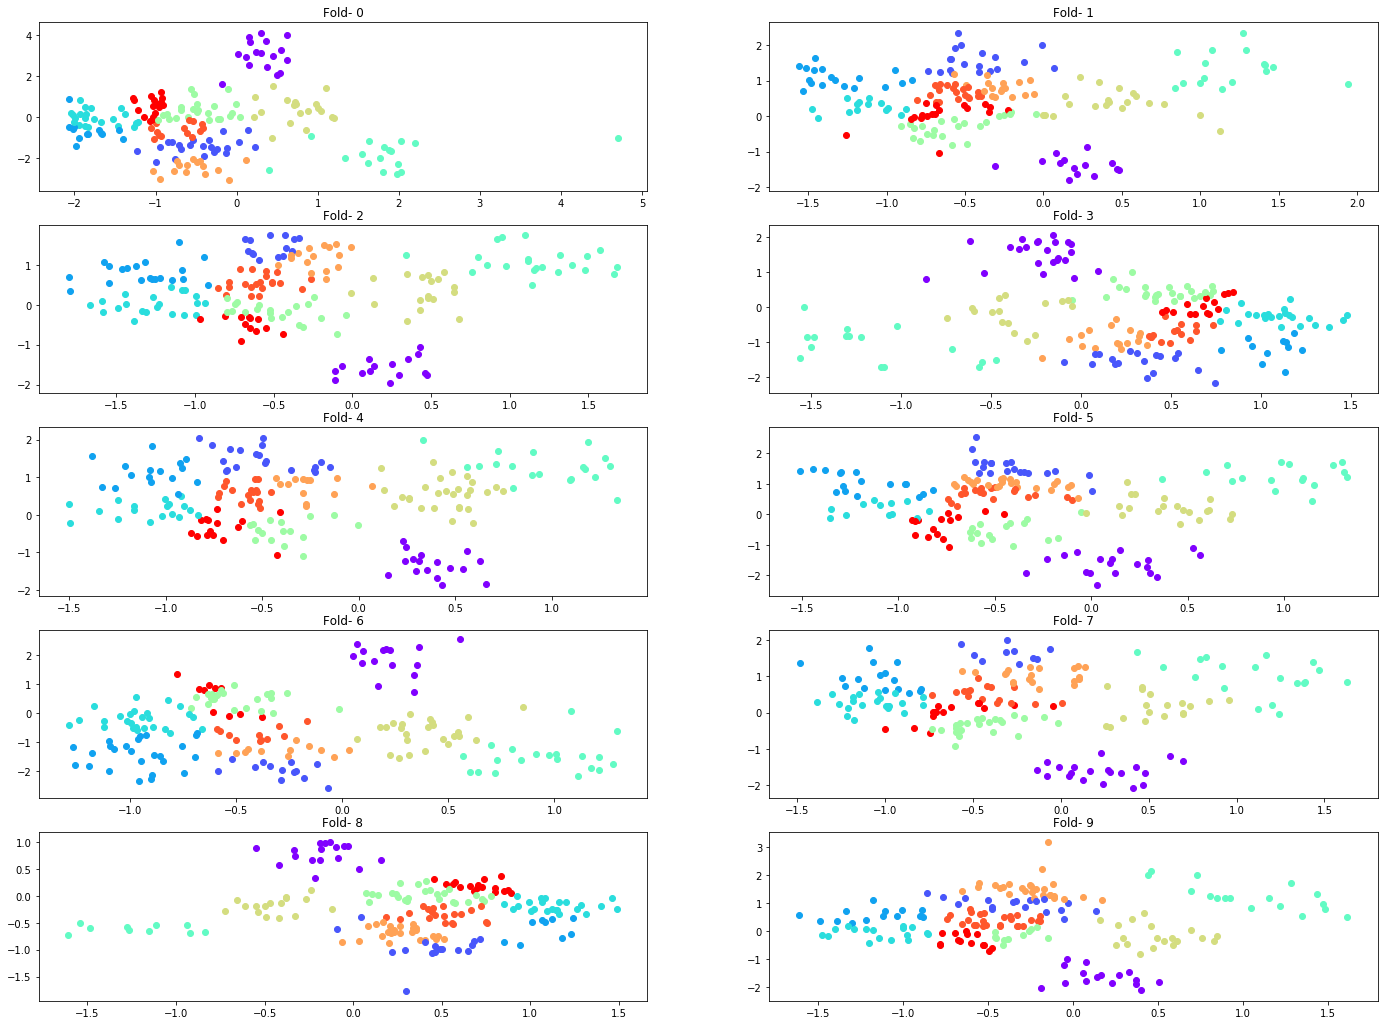

In [132]:
with open('digits.csv', 'r') as csvfile:
    digitDataset = np.asarray(list(csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)))
    
x = digitDataset[:, :-1]
y = digitDataset[:, -1:]
print("x: ", x.shape)
print("y: ", y.shape)

fisher_proj = fisher_projection(2)

# get the indices for k-fold cross validation
k = 10
k_folded_train_indices, k_folded_test_indices = get_k_fold_indices(k, y.shape[0], shuffle=True)

# get colors for each class for plotting the predictions
classes = list(np.unique(y))
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
plotlabels = {classes[c] : colors[c] for c in range(len(classes))}

plt.figure(figsize=(24, 18))
row = k // 2
col = 2
if row*col != k:
    row += 1
    
folds_errors = []

for fold, train_indices in enumerate(k_folded_train_indices):
    test_indices = k_folded_test_indices[fold]
    
    train_x = x[train_indices]
    test_x = x[test_indices]
    train_y = y[train_indices]
    test_y = y[test_indices]
    
    fisher_proj.fit(train_x, train_y)
    projected_train_features = fisher_proj.projected_x
    projected_test_features = fisher_proj.project(test_x)

    clf = gaussian_discriminant()
    clf.fit(projected_train_features, train_y)
    
    train_accuracy, train_predictions = clf.score(projected_train_features, train_y)
    accuracy, predictions = clf.score(projected_test_features, test_y)
    folds_errors.append([1 - train_accuracy, 1 - accuracy])
    
    plt.subplot(row, col, fold + 1)
    plt.title(f'Fold- {fold}')
    for point, prediction in zip(projected_test_features, predictions):
        plt.scatter(point[0], point[1], color=plotlabels[prediction])
        
    print(f'Fold#{fold} of {k} done')

# print(all_projected_test_features)
errors_df = pd.DataFrame(np.multiply(folds_errors, 100), columns = ["Train errors(%)", "Test errors(%)"])
errors_df

In [129]:
print("mean errors: ", np.mean(folds_before_fisher_errors, axis=0))

mean errors:  [0.29642095 0.32162632]


In [130]:
plt.show()